<a href="https://colab.research.google.com/github/davidraamirez/GradientWithoutBackpropagation/blob/main/LogisticRegression_bwd_gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import the necessary packages**



In [1]:
import torch
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

In [2]:
%pip install torchmetrics --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 4.3 MB/s eta 0:00:00


In [3]:
import torchmetrics
import torchvision

In [4]:
from torch import nn

In [5]:
import time 

In [6]:
import matplotlib.pyplot as plt

# **Loading and preprocessing the data**

In [7]:
#Load the dataset
penguins = tfds.load('penguins', as_supervised=True, split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/334 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/penguins/processed/1.0.0.incomplete5H8OGX/penguins-train.tfrecord*...:   0…

Dataset penguins downloaded and prepared to /root/tensorflow_datasets/penguins/processed/1.0.0. Subsequent calls will reuse this data.


In [8]:
X, y = penguins.batch(500).get_single_element()
X, y = X.numpy(), y.numpy()

In [9]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, stratify=y)

In [10]:
Xtrain = torch.from_numpy(Xtrain).float()
Xtest = torch.from_numpy(Xtest).float()

In [11]:
ytrain = torch.from_numpy(ytrain).long()
ytest = torch.from_numpy(ytest).long()

# **Define Logistic Regression**

In [12]:
class SimpleLogisticRegression(nn.Module):
  def __init__(self, input_size, w, b):
    super().__init__()
    self.weight = nn.Parameter(w)
    self.bias = nn.Parameter(b)

  def forward(self, x):
    x = x.reshape(1, -1)
    return torch.softmax(x@self.weight + self.bias, 1)

In [13]:
# We check if CUDA is available.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


# **Initialize the parameters**

In [14]:
# We initialize the parameters randomly and the model with an input size
w = torch.randn((4, 3), requires_grad=True)
b = torch.randn((3, ), requires_grad=True)
LG = SimpleLogisticRegression(4, w, b).to(device)

In [15]:
# We try our model with the first example
print(LG(Xtrain[0].to(device)))

tensor([[0.6066, 0.1515, 0.2420]], grad_fn=<SoftmaxBackward0>)


Calculate predictions

In [16]:
def pred(x,w,b):
  ypred=torch.randn((x.shape[0],3))
  for j in range (x.shape[0]):
    xj = x[j].reshape(1, -1)
    ypred[j]=torch.softmax(xj@w+b,1)
  return ypred

In [17]:
ypred=pred(Xtrain,w,b)

# **Define accuracy**

In [18]:
def accuracy(ytrue, ypred):
  return (ypred.argmax(1) == ytrue).float().mean()

In [19]:
# Average accuracy at initialization is 33% (random guessing).
accuracy(ytrain.to(device),ypred.to(device))

tensor(0.4360)

# **Define cross entropy**

In [20]:
def cross_entropy(ytrue,ypred):
  return - ypred[torch.arange(0, ypred.shape[0]), ytrue].log().mean()

In [21]:
print(cross_entropy(ytrain.to(device),ypred.to(device)))

tensor(1.9253, grad_fn=<NegBackward0>)


# **Train and evaluate the network**

In [22]:
def train_bwd_gradient(x,y):

  x,y=x.to(device),y.to(device)

  losses = [] # Vector with the cross entropy values of test set
  accuracies = [] # Vector with the accuracy values of test set
  errors=[] # Vector with the number of misclassification of the test set

  l_rate0 = 0.2 # Learning rate used 

  # Initialize the parameters
  w = torch.randn((4, 3), requires_grad=True)
  b = torch.randn((3, ), requires_grad=True)

  w, b = w.to(device), b.to(device)

  ypred=pred(x,w,b)
  ypred = ypred.to(device)
  loss = cross_entropy(y,ypred) # Loss function

  # Calculate the start time 
  t=0
  t0=time.time()
  print('Time', t, 'loss', loss)

  while (loss>0.3): 

    loss.backward()

    with torch.no_grad():
      
      # Apply gradients 
      w -= 0.01*w.grad
      b -= 0.01*b.grad

      # Gradients are accumulated: we need to zero them out before the next iteration.
      w.grad.zero_()
      b.grad.zero_()
    
    # We calculate the number of misclassification of the test set with the updated model and we add to the errors vector
    LG = SimpleLogisticRegression(4, w, b).to(device)
    ypredT = torch.randn(Xtest.size(0),3)
    error=0
    for i in range (Xtest.size(0)):
      ypredT[i]=LG(Xtest[i].to(device))
      if (LG(Xtest[i].to(device)).argmax(1)- ytest[i])!=0:
        error = error+ 1
    errors.append(error)
    ypredT = ypredT.to(device)

    ypred=pred(x,w,b)
    
    # We calculate the accuracy of the test set with the updated model and we add to the accuracy vector
    accuracies.append(accuracy(ytest,ypredT).item())

    # We calculate the cross_entropy of the test set with the updated model and we add to the accuracy vector
    loss = cross_entropy(y,ypred.to(device))
    lossT = cross_entropy(ytest,ypredT)
    losses.append(lossT.detach().item())

    #We add the execution time of the iteration
    t1=time.time()
    t+=t1-t0
    t0=t1
    print('Time', t, 'loss', loss)
  
  return w,b,errors,losses,accuracies


In [23]:
w, b,errors,losses,accuracies = train_bwd_gradient(Xtrain, ytrain)

Se han truncado las últimas 5000 líneas del flujo de salida.
Time 232.7929563522339 loss tensor(0.4550, grad_fn=<NegBackward0>)
Time 232.83200907707214 loss tensor(0.4550, grad_fn=<NegBackward0>)
Time 232.8943154811859 loss tensor(0.4549, grad_fn=<NegBackward0>)
Time 232.94060635566711 loss tensor(0.4549, grad_fn=<NegBackward0>)
Time 232.97989463806152 loss tensor(0.4548, grad_fn=<NegBackward0>)
Time 233.01735877990723 loss tensor(0.4548, grad_fn=<NegBackward0>)
Time 233.06544184684753 loss tensor(0.4547, grad_fn=<NegBackward0>)
Time 233.10458993911743 loss tensor(0.4547, grad_fn=<NegBackward0>)
Time 233.1448369026184 loss tensor(0.4546, grad_fn=<NegBackward0>)
Time 233.18723845481873 loss tensor(0.4546, grad_fn=<NegBackward0>)
Time 233.22599911689758 loss tensor(0.4545, grad_fn=<NegBackward0>)
Time 233.26525735855103 loss tensor(0.4545, grad_fn=<NegBackward0>)
Time 233.31175875663757 loss tensor(0.4544, grad_fn=<NegBackward0>)
Time 233.3509213924408 loss tensor(0.4544, grad_fn=<NegBac

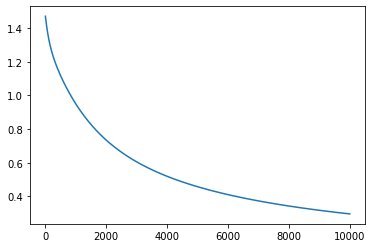

In [24]:
plt.plot(losses)

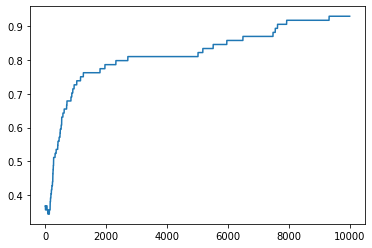

In [25]:
plt.plot(accuracies)

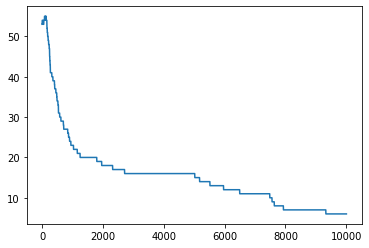

In [26]:
plt.plot(errors)